# Importy

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time

# Wczytanie danych

In [165]:
df = pd.read_csv('data4.csv')

In [166]:
y = pd.DataFrame(df['isGoal'])
X = df.drop(['isGoal'], axis=1)

In [167]:
X.head()

match_minute  match_second  position_x  position_y  play_type BodyPart  \
0            29            54       23.69        4.99  Open Play     Left   
1            11            33       28.93      -11.22  Open Play     Left   
2            61            25        9.98       -5.24  Open Play     Head   
3            73            45        4.49       -5.74  Open Play    Right   
4            44            40        7.98      -12.97  Open Play    Right   

   Number_Intervening_Opponents  Number_Intervening_Teammates  \
0                             4                             2   
1                             4                             1   
2                             3                             1   
3                             2                             0   
4                             1                             0   

  Interference_on_Shooter outcome  ...  Interference_on_Shooter_Code  \
0                  Medium  Missed  ...                             2   
1                     Low  Missed  ...                             1   
2                    High  Missed  ...                             3   
3                     Low  Missed  ...                             1   
4                  Medium   Saved  ...                             2   

   distance_to_goalM  distance_to_centerM      angle  isFoot  isHead  \
0          24.212265             5.001769  11.922004       1       0   
1          31.039134            11.246462  21.243463       1       0   
2          11.277751             5.252358  27.757313       0       1   
3           7.298171             5.753538  52.031899       1       0   
4          15.254368            13.000590  58.457635       1       0   

   header_distance_to_goalM  High  Low  Medium  
0                  0.000000     0    0       1  
1                  0.000000     0    1       0  
2                 11.277751     1    0       0  
3                  0.000000     0    1       0  
4                  0.000000     0    0       1  

[5 rows x 29 columns]

In [168]:
y.head()

isGoal
0       0
1       0
2       0
3       0
4       0

# Przygotowanie danych

### Uwzględnienie wybranych cech: 
- Współrzędna x strzelającego,
- Współrzędna y strzelającego,
- Dystans do bramki,
- Kąt do bramki,
- Minuta meczu,
- Liczba przeciwników przed piłką,
- Liczba zawodników ze swojej drużyny przed piłką,
- Część ciała.

In [169]:
X.columns

Index(['match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'BodyPart', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome',
       'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r',
       'position_xM_std', 'position_yM_std', 'position_xM_std_r',
       'position_yM_std_r', 'BodyPartCode', 'Interference_on_Shooter_Code',
       'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot', 'isHead',
       'header_distance_to_goalM', 'High', 'Low', 'Medium'],
      dtype='object')

In [170]:
X_extracted = X[['position_x', 
                 'position_y',
                 'distance_to_goalM', 
                 'angle', 
                 'match_minute', 
                 'Number_Intervening_Opponents', 
                 'Number_Intervening_Teammates', 
                 'isFoot', 
                 'isHead']]

In [171]:
X_extracted['isFoot'] = X_extracted['isFoot'].astype('category')
X_extracted['isHead'] = X_extracted['isHead'].astype('category')

C:\Users\s478991\AppData\Local\temp\ipykernel_3956\2392787789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_extracted['isFoot'] = X_extracted['isFoot'].astype('category')
C:\Users\s478991\AppData\Local\temp\ipykernel_3956\2392787789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_extracted['isHead'] = X_extracted['isHead'].astype('category')


In [172]:
X_extracted.head()

position_x  position_y  distance_to_goalM      angle  match_minute  \
0       23.69        4.99          24.212265  11.922004            29   
1       28.93      -11.22          31.039134  21.243463            11   
2        9.98       -5.24          11.277751  27.757313            61   
3        4.49       -5.74           7.298171  52.031899            73   
4        7.98      -12.97          15.254368  58.457635            44   

   Number_Intervening_Opponents  Number_Intervening_Teammates isFoot isHead  
0                             4                             2      1      0  
1                             4                             1      1      0  
2                             3                             1      0      1  
3                             2                             0      1      0  
4                             1                             0      1      0

### Podział danych na zbiór treningowy oraz zbiór testowy

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_extracted, y, test_size=0.2, random_state=1)

In [174]:
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [175]:
count_class_0, count_class_1 = y_train.value_counts()
print ('Oddane strzały w zbiorze danych: ', count_class_0)
print ('Gole trafione w zbiorze danych: ', count_class_1)

Oddane strzały w zbiorze danych:  7226
Gole trafione w zbiorze danych:  906


In [176]:
# Class imbalance in training data

scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

7.975717439293598

# Trening danych

In [177]:
from xgboost import XGBClassifier

In [178]:
# Define the xgboost model
xgb_model = XGBClassifier(enable_categorical=True, tree_method='hist', objective='binary:logistic')

In [179]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.01, 0.001, 0.0001],
              'max_depth': [3, 5, 7, 8, 9],
              'n_estimators': [100, 150, 200, 250, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [180]:
start_time = time.time()

In [181]:
# Perform nested cross-validation with grid search

grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [182]:
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

In [183]:
# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [184]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print (f"Model Training Time: {xgb_training_time:.3f} seconds")

Best parameters:  {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 7.975717439293598}
Model Training Time: 677.443 seconds


# Ewaluacja modelu

### Dane treningowe

Text(0.5, 1.0, 'Confusion Matrix - Train Set')

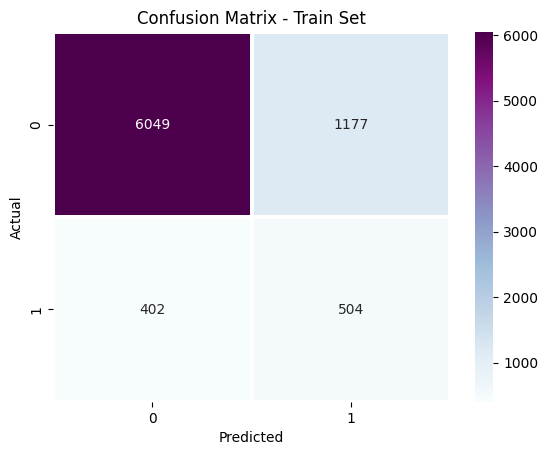

In [185]:
# Confusion Matrix for Training Data
cm_train_xg = confusion_matrix(y_train, best_xgb_model.predict(X_train))

ax = sns.heatmap(cm_train_xg, annot=True, cmap='BuPu', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Train Set')

In [186]:
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88      7226
           1       0.30      0.56      0.39       906

    accuracy                           0.81      8132
   macro avg       0.62      0.70      0.64      8132
weighted avg       0.87      0.81      0.83      8132



In [187]:
# xgb.to_graphviz(best_xgb_model, num_trees=1)

### Dane testowe

Text(0.5, 1.0, 'Confusion Matrix - Test Set')

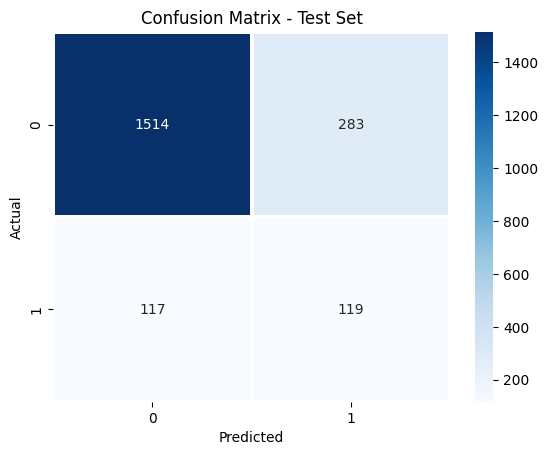

In [188]:
# Evaluate the performance of the best model on the testing set
y_pred_xgb = best_xgb_model.predict(X_test)

# Confusion Matrix for Testig Data
cm_test_xgb = confusion_matrix(y_test, y_pred_xgb)

ax = sns.heatmap(cm_test_xgb, annot=True, cmap='Blues', fmt='g', linewidth=1.5)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

In [189]:
# Classfication report for testing data
print (classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1797
           1       0.30      0.50      0.37       236

    accuracy                           0.80      2033
   macro avg       0.61      0.67      0.63      2033
weighted avg       0.85      0.80      0.82      2033



In [191]:
print(f'Zbiór danych testowych zawiera {len(y_test)} oddane strzały, gdzie {y_test.sum()["isGoal"]} to strzały trafione.')
print(f'Dokładność klasyfikacji, czy strzał jest bramką, czy nie, wynosi {best_xgb_model.score(X_test, y_test):.2f}%.')
print(f'klasyfikator uzyskał ROC-AUC na poziomie {roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1]):.2f}%.')

Zbiór danych testowych zawiera 2033 oddane strzały, gdzie 236 to strzały trafione.
Dokładność klasyfikacji, czy strzał jest bramką, czy nie, wynosi 0.80%.
klasyfikator uzyskał ROC-AUC na poziomie 0.75%.


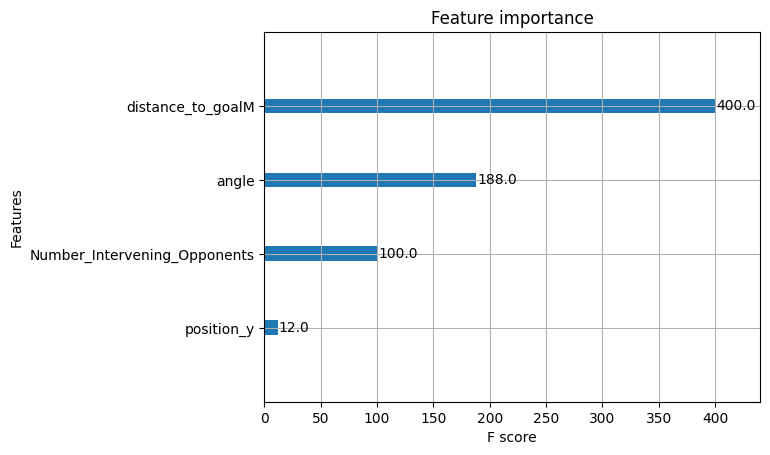

In [192]:
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

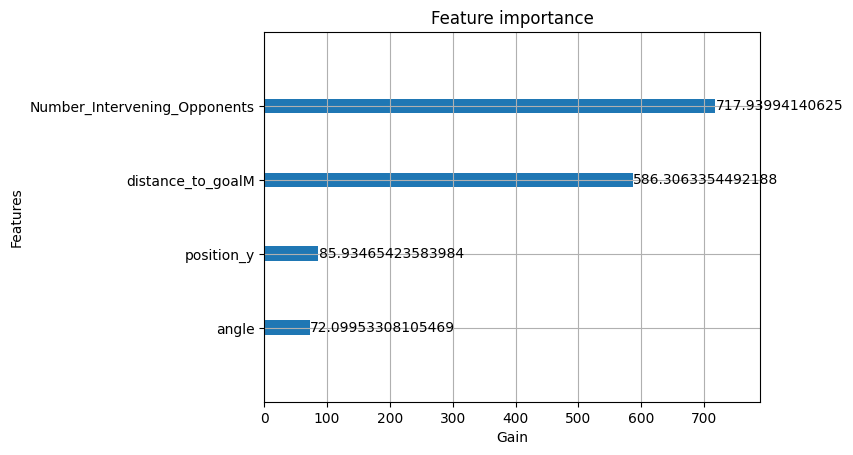

In [193]:
xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

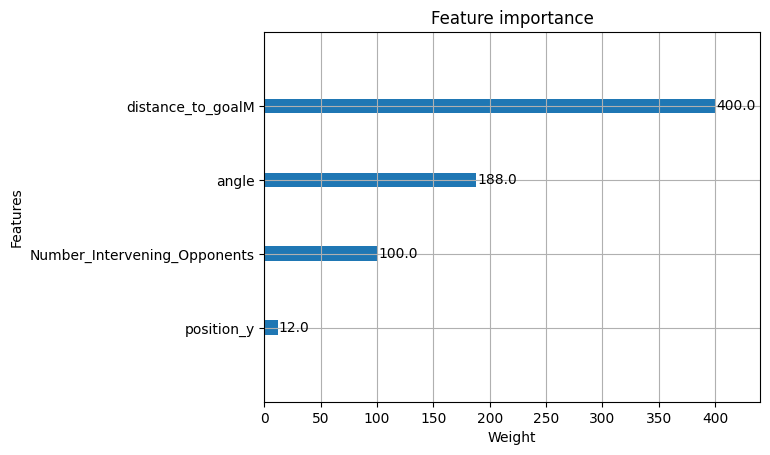

In [194]:
xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()

# Podsumowanie

In [195]:
prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))
prec_xgb_test = precision_score(y_test, y_pred_xgb)
rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))
rec_xgb_test = recall_score(y_test, y_pred_xgb)
acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))
acc_xgb_test = accuracy_score(y_test, y_pred_xgb)
train_time = xgb_training_time/60

In [196]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['XG Boost'],
                          'Training Accuracy': acc_xgb_train, 
                          'Training Precision': prec_xgb_train,
                          'Training Recall':rec_xgb_train,
                          'Testing Accuracy': acc_xgb_test, 
                          'Testing Precision': prec_xgb_test,
                          'Testing Recall':rec_xgb_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'white'})

# Zapisywanie modelu

In [197]:
from joblib import dump
dump(best_xgb_model, 'xgboost.joblib') 

['xgboost.joblib']

## Wczytywanie modelu

In [198]:
from joblib import load

model2 = load('xgboost.joblib')

In [199]:
model2.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': True,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.001,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 7.975717439293598,
 'subsample': None,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}